In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from bokeh.io import show, output_notebook
from bokeh.plotting import figure, gridplot
from bokeh.models import LinearAxis, Range1d
output_notebook()

Loading BokehJS ...

### GPU
指定使用的 GPU 编号。  
`watch -n 1 nvidia-smi` 实时查看 GPU 的运行状态。 

In [2]:
torch.cuda.set_device("cuda:5")
torch.cuda.current_device()
# device = torch.device("cuda:5")
# xxx.to(device)

5

### Data
通过`torchvision.datasets`下载`MNIST`数据。  
训练集：`train=True`  
测试集：`train=False`  
常用的还有`torchvision.datasets.ImageFolder()`，按文件夹取图片。  

`torchvision.transforms`可以对图片做处理。

In [3]:
train_dataset = dsets.MNIST(root='../dataset', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='../dataset', train=False, transform=transforms.ToTensor(), download=True)

In [4]:
batch_size = 50
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

### Model
构造前馈神经网络

In [5]:
class FNN(nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out):
        super().__init__()
        self.fc1 = nn.Linear(dim_in, dim_hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(dim_hidden, dim_out)
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [6]:
dim_in = 28*28
dim_hidden = 500
dim_out = 10
lrate = 0.001
epochs = 40

model = FNN(dim_in, dim_hidden, dim_out).double().cuda()
criterion = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=lrate)

注意：每次反向传播的时候都需要将参数的梯度归零。  
`optim.step()`则在每个`Variable`的`grad`都被计算出来后，更新每个`Variable`的数值

在每次训练中都用`train_loader`中的一个`batch`作为训练数据。  
`Tensor.cuda()` 每个 `batch` 在实际使用之前，都先移入 `GPU` 后进行计算。  

In [7]:
result = []
for e in range(epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.reshape(-1, 28*28).double().cuda()
        targets = targets.cuda()
        optim.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optim.step()
    result.append(float(loss))
    
fig = figure()
fig.line(range(len(result)), result)
show(fig)

### Result
与 CPU 训练的情况对比，GPU 的迭代次数从 20 增加到 40，但时间从  8m 33s 减少到 6m 33s，且在训练过程中对 CPU 的占用明显减少。  
由于迭代次数增加，准确率也从 90.20 % 增加到 91.74 %

`re = torch.max(Tensor,dim)`, 返回的re为一个二维向量，其中`re[0]`为最大值的`Tensor`，re[1]为最大值对应的`index`

In [8]:
correct = 0
total = 0
wrong_count = 0
wrong_classify = []
for i, (inputs, targets) in enumerate(test_loader):
    targets = targets.cuda()
    inputs = inputs.reshape(-1, 28*28).double().cuda()
    outputs = model(inputs)
    _, preds = torch.max(outputs.data, 1)
    total += len(outputs)
    correct += (preds == targets).sum()
    if wrong_count < 5 and preds != targets:
        wrong_classify.append([inputs.data, preds, targets])
        wrong_count += 1
accuracy = 100 * correct.double() / total
print('Accuracy of the model on the 10000 test images: %.2f %%' % (accuracy))

Accuracy of the model on the 10000 test images: 91.74 %


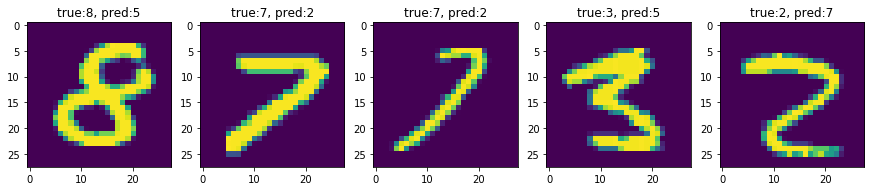

In [9]:
plt.figure(figsize=(15, wrong_count*15))
for i, (img, preds, truth) in enumerate(wrong_classify):
    img = img.reshape(28, 28).cpu().numpy()
    plt.subplot(1, wrong_count, i+1)
    plt.imshow(img)
    plt.title('true:%i, pred:%i' % (truth, preds))
plt.show()

### Save Model

In [10]:
torch.save(model.state_dict(), 'feedfoward_nn_cuda.pkl')